In [1]:
#basic libraries
import pandas as pd
import numpy as np
from math import *

#graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

#system libraries
import os
import statistics
from datetime import datetime

#sklearn
import sklearn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.linear_model import SGDClassifier

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

#keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers.core import Dense,Activation,Dropout
from keras.datasets import mnist
from keras.wrappers.scikit_learn import KerasClassifier

In [3]:
#reading in the dataset
#test = pd.read_csv("digit-recognizer/test.csv")
#train = pd.read_csv("digit-recognizer/train.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

# Cleaning the data

#### Checking for NULLS

In [4]:
test.isnull().values.any()

False

In [5]:
train.isnull().values.any()

False

There are no missing values in either datasets. If there were, we would have filled it with the average value of the datasets

# Fitting, Scaling and Splitting the Data into Train and Test Data

In [6]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train["label"].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

C:\Users\kerry\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

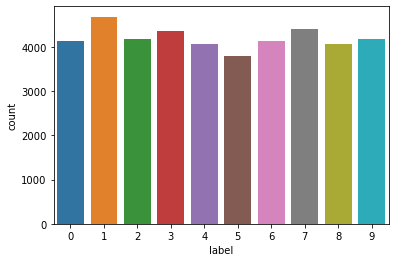

In [8]:
sns.countplot(train['label'])

Text(0.5, 1.0, 'Number 0')

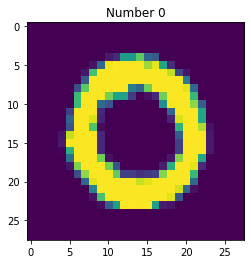

In [9]:
#to show the numbers. This is pretty cool 
zero = train.iloc[1, 1:] #for the first column
zero = zero.values.reshape(28,28)
plt.imshow(zero)
plt.title("Number 0")

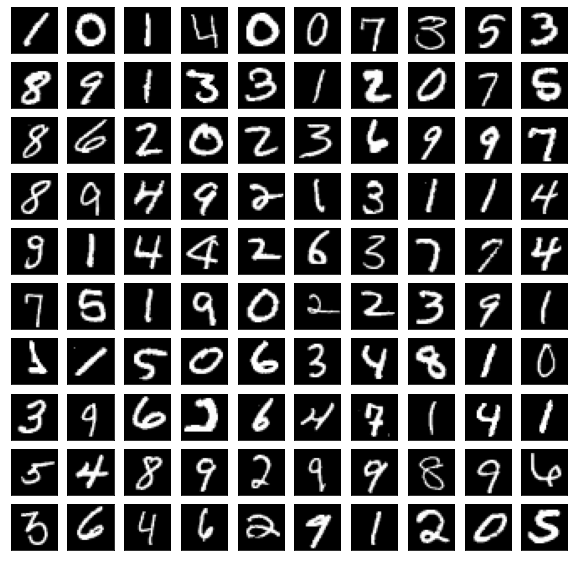

In [10]:
#other visualization
plt.figure(figsize =(10, 10))
for i in range(100):
    plt.subplot(10,10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.array(train.drop('label', axis = 1))[i].reshape(28,28), cmap = 'gray')
plt.show()

# Support Vector Machine

In [11]:
#time for the train test split
x = train.iloc[:, train.columns != 'label']
y = train["label"]

#scale
scaler = StandardScaler()
xScale = scaler.fit_transform(x)

#split 
x_train, x_test, y_train, y_test = train_test_split(xScale, y, test_size = 0.25, random_state=45931)

In [12]:
#library ahoy
model = SVC(kernel = "linear")

#fit the code into SVC
model.fit(x_train,y_train)

#predict
y_pred = model.predict(x_test)


In [13]:
#results
print("Accuracy:", accuracy_score(y_test,y_pred))
print("Root Mean Squared Error:", mean_squared_error(y_test,y_pred))

Accuracy: 0.9200952380952381
Root Mean Squared Error: 1.3564761904761904


In [14]:
#excel output to kaggle
# y_pred = model.predict(test)
# res = pd.DataFrame(y_pred)
# res.index = test.index + 1 # its important for comparison
# res.columns = ["Label"]
# res.index.rename('ImageId', inplace = True)
# res.to_csv("y_prediction_svm.csv")

# Convoluted Neural Networks

https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/
We will use the ReLu activation function since it is easy to implement, doesn't lead to excessive orders of magnitude in parameters and doesn't succumb to the vanishing gradient effect

Our convolutional layer will use a small filter of (3,3) over 32 layers. (Add some sentences on why these parameters) The filter will be initialized to the He weight filter scheme

The max pooling layer will be the standard (2,2)

We will flatten the data so that we can feed the 1D array into a linear 100 node layer, which will finally be passed into the classification layer that consists of 10 final nodes

In [15]:
#https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
#Will not be doing one hot encoding, so will use the sparse categorical crossentropy

def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    # compile model
    opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [49]:
#parse out what is the data verse the label 
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
Train_X = np.array(train_x)    #for better computation 

#reshape to format needed for keras model 
Train_X = Train_X.reshape(42000,28,28)

In [50]:
#scale
Train_X = Train_X/255

In [51]:
#split train data set into train and test 
X_train, X_test, Y_train, Y_test = train_test_split(Train_X, train_y, test_size = 0.25, random_state=45931)

In [52]:
#train model
model = define_model()

In [53]:
#fit model
#Will test how well the model performs with regular epochs and batch sizes
history = model.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/10
985/985 [==============================] - 10s 10ms/step - loss: 0.2336 - accuracy: 0.9287 - val_loss: 0.1141 - val_accuracy: 0.9653
Epoch 2/10
985/985 [==============================] - 10s 10ms/step - loss: 0.0804 - accuracy: 0.9758 - val_loss: 0.0766 - val_accuracy: 0.9773
Epoch 3/10
985/985 [==============================] - 10s 10ms/step - loss: 0.0496 - accuracy: 0.9847 - val_loss: 0.0666 - val_accuracy: 0.9800
Epoch 4/10
985/985 [==============================] - 10s 10ms/step - loss: 0.0330 - accuracy: 0.9902 - val_loss: 0.0610 - val_accuracy: 0.9824
Epoch 5/10
985/985 [==============================] - 10s 10ms/step - loss: 0.0218 - accuracy: 0.9942 - val_loss: 0.0629 - val_accuracy: 0.9810
Epoch 6/10
985/985 [==============================] - 10s 10ms/step - loss: 0.0162 - accuracy: 0.9950 - val_loss: 0.0575 - val_accuracy: 0.9832
Epoch 7/10
985/985 [==============================] - 10s 10ms/step - loss: 0.0109 - accuracy: 0.9974 - val_loss: 0.0549 - val_accuracy:

In [54]:
#local test model 
acc = model.evaluate(X_test, Y_test)
acc

329/329 [==============================] - 1s 2ms/step - loss: 0.0597 - accuracy: 0.9842


[0.059712622314691544, 0.9841904640197754]

In [55]:
cnn_Y_predict = np.argmax(model.predict(X_test), axis=-1)

In [56]:
#For confusion Matrix
cnn_Y_test = Y_test

In [57]:
print("Acurracy CNN: ", acc[1]*100)
print("RMSE: ", mean_squared_error(cnn_Y_test,cnn_Y_predict))

Acurracy CNN:  98.41904640197754
RMSE:  0.30314285714285716


In [58]:
#Try training on entire Train set
history_fullTrain = model.fit(Train_X, train_y, epochs=10, batch_size=32)

Epoch 1/10
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0250 - accuracy: 0.9928
Epoch 2/10
1313/1313 [==============================] - 12s 10ms/step - loss: 0.0133 - accuracy: 0.9963
Epoch 3/10
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0078 - accuracy: 0.9982
Epoch 4/10
1313/1313 [==============================] - 13s 10ms/step - loss: 0.0052 - accuracy: 0.9988
Epoch 5/10
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0028 - accuracy: 0.9996
Epoch 6/10
1313/1313 [==============================] - 13s 10ms/step - loss: 0.0018 - accuracy: 0.9997
Epoch 7/10
1313/1313 [==============================] - 12s 9ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 8/10
1313/1313 [==============================] - 12s 9ms/step - loss: 7.1857e-04 - accuracy: 1.0000
Epoch 9/10
1313/1313 [==============================] - 12s 9ms/step - loss: 5.8959e-04 - accuracy: 1.0000
Epoch 10/10
1313/1313 [==============================] - 12s 9

In [59]:
#Kaggle Test set 
Test_X = np.array(test)    #for better computation 
Test_X = Test_X.reshape(28000,28,28)

In [60]:
Test_X.shape

(28000, 28, 28)

In [61]:
#Run mode on Kaggle Test Predictions
pred = np.argmax(model.predict(Test_X), axis=-1)

In [62]:
#Save Kaggle predictions to submit
# df = pd.DataFrame(pred)
# df.index = test.index + 1 
# df.columns = ["Label"]
# df.index.rename('ImageId', inplace = True)
# df.to_csv("CNN_prediction_results2.csv")

# K Nearest Neighbor

In [63]:
#parse out what is the data verse the label 
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]

In [64]:
#split train data set into train and test 
x_train, x_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.25, random_state=45931)

In [65]:
#get dimensions of train set 
train_shape = x_train.shape
test_shape = x_test.shape
print("train: ", train_shape, "\n", "test: ", test_shape)

train:  (31500, 784) 
 test:  (10500, 784)


In [66]:
from sklearn.neighbors import KNeighborsClassifier

#define classifier 
knn = KNeighborsClassifier(n_neighbors = 5)

#fit model
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [67]:
y_predict = knn.predict(x_test)

In [68]:
#test 
print("KNN Accuracy",knn.score(x_test, y_test))
print("Root Mean Squared Error:", mean_squared_error(y_test, y_predict))

KNN Accuracy 0.9672380952380952
Root Mean Squared Error: 0.5984761904761905


In [69]:
y_pred = knn.predict(test)
res = pd.DataFrame(y_pred)
res.index = test.index + 1 # its important for comparison
res.columns = ["Label"]
res.index.rename('ImageId', inplace = True)
res.to_csv("y_prediction_knn.csv")

# Artificial Neural Networks

In [70]:
# Defining the Neural Network model
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(784,)),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(10, activation='sigmoid'),
])

In [71]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               200960    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                      

In [73]:
# compiling the model with the loss function
# ref-https://keras.io/api/optimizers/
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

In [74]:
# predicting the test labels given the tset dataset.
Y_predict = model.predict(test)
Y_predict = np.argmax(Y_predict, axis=1)

# Gradient Descent Back Propogation

In [75]:
# compiling the model with the loss function
# ref-https://keras.io/api/optimizers/
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule)

In [76]:
model.compile(loss="categorical_crossentropy",
              optimizer=optimizer,
              metrics = ['accuracy'])

In [77]:
# One Hot Encoding the labels
Y_train_enc = to_categorical(y_train, num_classes = 10)
Y_train_enc[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [78]:
# fitting the model
model.fit(x_train, Y_train_enc, batch_size=100, epochs=100)

Epoch 1/100
315/315 [==============================] - 2s 3ms/step - loss: 1.9423 - accuracy: 0.3325
Epoch 2/100
315/315 [==============================] - 1s 3ms/step - loss: 1.3517 - accuracy: 0.5684
Epoch 3/100
315/315 [==============================] - 1s 3ms/step - loss: 1.0670 - accuracy: 0.6833
Epoch 4/100
315/315 [==============================] - 1s 3ms/step - loss: 0.8799 - accuracy: 0.7434
Epoch 5/100
315/315 [==============================] - 1s 3ms/step - loss: 0.7681 - accuracy: 0.7747
Epoch 6/100
315/315 [==============================] - 1s 3ms/step - loss: 0.6888 - accuracy: 0.8012
Epoch 7/100
315/315 [==============================] - 1s 3ms/step - loss: 0.6237 - accuracy: 0.8206
Epoch 8/100
315/315 [==============================] - 1s 3ms/step - loss: 0.5796 - accuracy: 0.8335
Epoch 9/100
315/315 [==============================] - 1s 3ms/step - loss: 0.5394 - accuracy: 0.8477
Epoch 10/100
315/315 [==============================] - 1s 3ms/step - loss: 0.5078 - accura

315/315 [==============================] - 1s 3ms/step - loss: 0.1397 - accuracy: 0.9632
Epoch 82/100
315/315 [==============================] - 1s 3ms/step - loss: 0.1376 - accuracy: 0.9633
Epoch 83/100
315/315 [==============================] - 1s 3ms/step - loss: 0.1338 - accuracy: 0.9646
Epoch 84/100
315/315 [==============================] - 1s 3ms/step - loss: 0.1376 - accuracy: 0.9634
Epoch 85/100
315/315 [==============================] - 1s 3ms/step - loss: 0.1405 - accuracy: 0.9631
Epoch 86/100
315/315 [==============================] - 1s 3ms/step - loss: 0.1300 - accuracy: 0.9650
Epoch 87/100
315/315 [==============================] - 1s 3ms/step - loss: 0.1325 - accuracy: 0.9640
Epoch 88/100
315/315 [==============================] - 1s 3ms/step - loss: 0.1300 - accuracy: 0.9656
Epoch 89/100
315/315 [==============================] - 1s 3ms/step - loss: 0.1278 - accuracy: 0.9651
Epoch 90/100
315/315 [==============================] - 1s 3ms/step - loss: 0.1225 - accuracy: 

In [79]:
# predicting the test labels given the tset dataset.
Y_predict = model.predict(test)
Y_predict = np.argmax(Y_predict, axis=1)

In [80]:
# printing predictions
Y_predict

array([2, 0, 9, ..., 3, 9, 2], dtype=int64)

# Confusion Matrix for ANN

In [81]:
# As we dont have ground truth given with in the text dataset.
# I have created my own test set using the  train set of the given dataset from kaggle using test_train_split.
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.25, random_state=45931)

In [82]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

Y_predict = model.predict(x_test)

(23625, 784)
(23625,)
(7875, 784)
(7875,)


In [83]:
Y_predict = np.argmax(Y_predict, axis=1)
print(Y_predict)

[2 2 6 ... 0 7 0]


In [84]:
# Accuracy using RMSE
print("Accuracy of ANN:", accuracy_score(y_test,Y_predict))
print("Root Mean Squared Error of ANN:", mean_squared_error(y_test,Y_predict))

Accuracy of ANN: 0.9954285714285714
Root Mean Squared Error of ANN: 0.08088888888888889


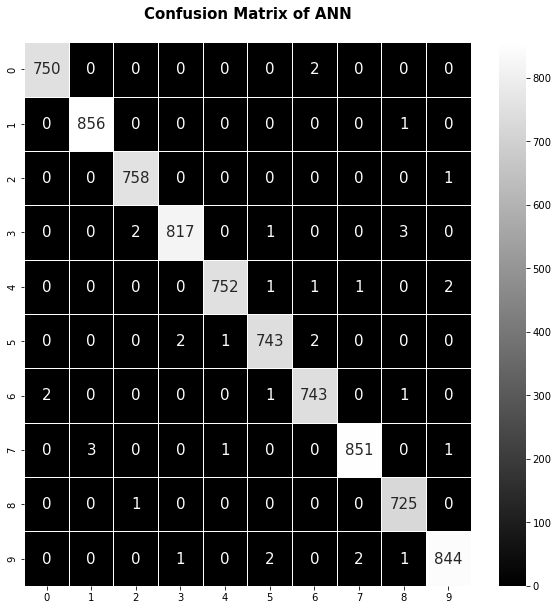

In [85]:
# ref - https://medium.com/analytics-vidhya/applying-ann-digit-and-fashion-mnist-13accfc44660
# ref - https://medium.com/@prtk13061992/mnist-dataset-using-deep-learning-algorithm-ann-c6f83aa594f5
# Accuracy using confusion matrix
#evaluate the model for testing dataset
con_mat=confusion_matrix(y_test,Y_predict)
plt.style.use('seaborn-deep')
plt.figure(figsize=(10,10))
sns.heatmap(con_mat,annot=True,annot_kws={'size': 15},linewidths=0.5,fmt="d",cmap="gray")
plt.title('Confusion Matrix of ANN\n',fontweight='bold',fontsize=15)
plt.show()

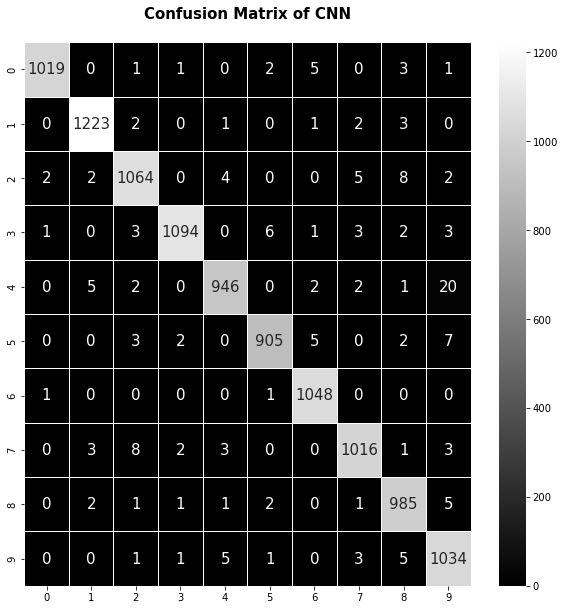

In [72]:
confusion=confusion_matrix(cnn_Y_test,cnn_Y_predict)
plt.style.use('seaborn-deep')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(confusion, annot=True,annot_kws={'size': 15},linewidths=0.5,fmt="d",cmap="gray")
plt.title('Confusion Matrix of CNN\n',fontweight='bold',fontsize=15)
plt.show()

# Performance Metrics

## SVM

Accuracy SVM: 0.9200952380952381  
Root Mean Squared Error of SVM: 1.3564761904761904  


## ANN 
Accuracy of ANN: 0.9962962962962963  
Root Mean Squared Error of ANN: 0.05502645502645503  

## KNN  
Accuracy of KNN: 0.9774603174603175  
Root Mean Squared Error of KNN: 0.4239153439153439


## CNN
Accuracy of CNN: 0.9845714569091797  
Root Mean Squared Error of KNN: 0.26695238095238094